# **CS419 Project**

## **Handwritten Text Recognition**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import sklearn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib
from torch.utils.tensorboard import SummaryWriter
!nvidia-smi

Thu May 13 13:57:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **GPU Utilization**

https://towardsdatascience.com/pytorch-switching-to-the-gpu-a7c0b21e8a99

In [ ]:
print('CuDA available:',torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

CuDA available: True
cuda


## **DataLoader (from Torchvision)**

In [ ]:
class EMNIST_Transform(object):
    def __init__(self):
      pass  # Do nothing
    def __call__(self,img):  # add whatever transforms that you want in here
        image = transforms.functional.rotate(img, 90)
        image = transforms.functional.flip(image)
        return image

In [ ]:
trainset=datasets.EMNIST(root='/content/drive/My Drive/Colab Notebooks/data', split= 'byclass', train=True, download=True, transform=transforms.ToTensor())#transforms.Compose([EMNIST_Transform(),transforms.ToTensor()]))
testset=datasets.EMNIST(root='/content/drive/My Drive/Colab Notebooks/data', split= 'byclass', train=False, download=True, transform=transforms.ToTensor())#transforms.Compose([EMNIST_Transform(),transforms.ToTensor()]))
print(len(trainset))
print(len(testset))
print(len(trainset)+len(testset))
print('ok')

697932
116323
814255
ok


## **CNN Model Declaration**
###Along with Loss and Optimizer functions

###Model Declaration

NN Layer size: (1568, 1984, 922, 62), LR = $10^{-4}$ (Tuned hyperparameters)

In [ ]:
class ModelOfNet(nn.Module):
  def __init__(self):
      super(ModelOfNet,self).__init__()

      self.convolve=nn.Sequential(
              nn.Conv2d(1,8,3,1,1),
              nn.ReLU(),
              nn.Conv2d(8,16,3,1,1),
              nn.ReLU(),
              nn.BatchNorm2d(16),
              nn.MaxPool2d(2,2),
              nn.Conv2d(16,16,3,1,1),
              nn.ReLU(),
              nn.Conv2d(16,32,3,1,1),
              nn.ReLU(),
              nn.BatchNorm2d(32),
              nn.MaxPool2d(2,2),
      )
      self.fullyconnect1=nn.Linear(1568,1984)
      self.fullyconnect2=nn.Linear(1984,992)
      self.fullyconnect3=nn.Linear(992,62)
      self.ReLU=nn.ReLU()

  def forward(self, x):
      x=self.convolve(x)
      x=x.view(x.size(0),-1)
      x=self.fullyconnect1(x)
      x=self.ReLU(x)
      x=self.fullyconnect2(x)
      x=self.ReLU(x)
      x=self.fullyconnect3(x)
      return x

model=ModelOfNet()
model=model.to(device)    #Transfer model to GPU, Data will be transferred in the validation/training time code

In [ ]:
print(model)

ModelOfNet(
  (convolve): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fullyconnect1): Linear(in_features=1568, out_features=1984, bias=True)
  (fullyconnect2): Linear(in_features=1984, out_features=992, bias=True)
  (fullyconnect3): Linear(in_features=992, out_features=62, bias=True)
  (ReLU): ReLU()
)


### Training the Model

In [ ]:
def trainmodel(epochs=10):
  splitval=18001
  trainlosses=[]
  vallosses=[]
  for epoch in range(epochs):  # loop over the dataset multiple times
    pathname='/content/drive/MyDrive/Colab Notebooks/data/epoch'+str(epoch)+'_state.pth'
    running_loss = 0.0
    mean_train_loss = 0.0
    mean_val_loss = 0.0
    for batchno,(inputs, labels) in enumerate(trainloader, start=0):
        # get the inputs, labels
        inputs, labels = inputs.to(device), labels.to(device)
        
        ########## TRAINING ##########
        if batchno<=splitval:
          # zero the parameter gradients
          updatefunction.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          assert outputs.shape[0]==labels.shape[0]
          loss = lossfunction(outputs, labels)
          loss.backward()
          updatefunction.step()

          # print statistics
          running_loss += loss.item()
          mean_train_loss += ((loss.item())/splitval)
          if batchno%1000==True:    # print every 1000 mini-batches
              print('[Epoch %d, Batch %5d]    train loss(prev. 1000 batches): %.5f'%(epoch, batchno, running_loss/1000))
              running_loss = 0.0

        ########## VALIDATION ##########
        
        if batchno>splitval:  
          # no gradient calc because validation
          with torch.no_grad():
            # forward + loss on validation
            outputs = model(inputs)
            assert outputs.shape[0]==labels.shape[0]
            loss = lossfunction(outputs, labels)

            # print statistics
            running_loss += loss.item()
            mean_val_loss += ((loss.item())/(nbatchtrain-splitval))
            if batchno%1000==True:    # print every 1000 mini-batches
                print('[Epoch %d, Batch %5d]    val loss(prev. 1000 batches): %.5f'%(epoch, batchno, running_loss/1000))
                running_loss = 0.0

    torch.save(model.state_dict(), pathname)
    trainlosses.append(mean_train_loss)
    vallosses.append(mean_val_loss)
    print("\nMean Training NLL Loss per batch in Epoch ", epoch,": ", mean_train_loss)
    print("Mean Validation NLL Loss per batch in Epoch ", epoch,": ", mean_val_loss,"\n\n")
  
  print('Finished Training')
  return trainlosses, vallosses

In [ ]:
batchsize=32;

nbatchtrain=np.ceil(len(trainset)/batchsize)
nbatchtest=np.ceil(len(testset)/batchsize)
print(nbatchtrain,nbatchtest)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)#, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=True)#, num_workers=2)

21811.0 3636.0


In [ ]:
lossfunction=torch.nn.CrossEntropyLoss()
updatefunction=torch.optim.Adam(model.parameters(), lr=1e-4)
# print('Completed running block')
trianlosses = []
vallosses = []
trainlosses , vallosses = trainmodel(40)

[Epoch 0, Batch     1]    train loss(prev. 1000 batches): 0.00821
[Epoch 0, Batch  1001]    train loss(prev. 1000 batches): 0.95424
[Epoch 0, Batch  2001]    train loss(prev. 1000 batches): 0.55217
[Epoch 0, Batch  3001]    train loss(prev. 1000 batches): 0.49267
[Epoch 0, Batch  4001]    train loss(prev. 1000 batches): 0.46644
[Epoch 0, Batch  5001]    train loss(prev. 1000 batches): 0.44144
[Epoch 0, Batch  6001]    train loss(prev. 1000 batches): 0.43953
[Epoch 0, Batch  7001]    train loss(prev. 1000 batches): 0.42810
[Epoch 0, Batch  8001]    train loss(prev. 1000 batches): 0.40790
[Epoch 0, Batch  9001]    train loss(prev. 1000 batches): 0.40826
[Epoch 0, Batch 10001]    train loss(prev. 1000 batches): 0.40421
[Epoch 0, Batch 11001]    train loss(prev. 1000 batches): 0.41107
[Epoch 0, Batch 12001]    train loss(prev. 1000 batches): 0.39422
[Epoch 0, Batch 13001]    train loss(prev. 1000 batches): 0.39819
[Epoch 0, Batch 14001]    train loss(prev. 1000 batches): 0.39092
[Epoch 0, 

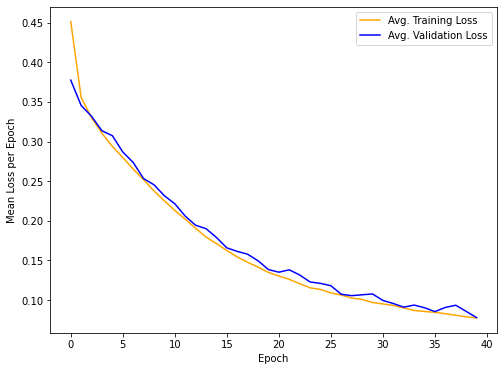

In [ ]:
# trainlosses=[0.5129978803183178, 0.4273219631610141,0.4060228041051212,0.3928437206852143,0.3824235347575767,0.37206574419726507,0.3677951769605193,0.36269607941817444,0.358419953567972,0.3535557034368578,0.35004186838025997,0.34698029307747874,0.34362296668714315,0.3403147358549131,0.33841489290754556,0.3350138107677777,0.3334502928492061,0.3316671283160579,0.3291295484169064,0.32736818996002354,0.3259702156892871,0.3236911146421479,0.3222962562300044,0.32052161754780284,0.318440612370047,0.3171138775201083,0.31607046701201574,0.31428024862792403,0.3130870406027457,0.3115595296169313,0.3115226574716841,0.30944701054187795,0.30759319465401186,0.30779635322602455,0.3069764904026577,0.3058501306037995,0.3048726816738562,0.3041840440864606,0.3027239188568045,0.302070626503403]
# vallosses=[0.4415333727096014, 0.4220744729433166,0.3986586449086052 ,0.38156375575057855 , 0.37562555830700756, 0.38186098251178907 , 0.37128814163561413,0.37386833092398264 ,0.35940554529389335 ,0.3606847558434548,0.3552467210369873,0.3460809017876232 , 0.34697001009514616 ,0.3427367443917932,0.3390800582200984,0.3380344654836754 ,0.3359785289579405 ,0.33492670209682396,0.32977292343211473,0.32907326343197946 , 0.32583788896072424,0.3237101684346444 , 0.32267770144081426 ,0.32565434086295386,0.32393324186443767 ,0.3230850171376014,0.3201020346587816,0.3202595472453148 , 0.3231053253953541 ,0.3176203414787994 ,0.3117130257697723,0.3130348183547101 ,0.31870454760595857 ,0.3127566350374638 ,0.3066819157118956 ,0.3095655523837001,0.3070144725298593,0.3043570769212528 ,0.30810278647351924 ,0.3035591028787168 ]
plt.figure(figsize=(8,6))
plt.plot(np.arange(40),trainlosses, label='Avg. Training Loss', color='orange')
plt.plot(np.arange(40),vallosses, label='Avg. Validation Loss', color='blue')
plt.ylabel('Mean Loss per Epoch')
plt.xlabel('Epoch')
plt.legend()
plt.show() 

In [ ]:
trainlosses

[0.45141224776796407,
 0.35555549285481036,
 0.33003178606317063,
 0.31038552942351977,
 0.2937659532174051,
 0.2798523348493051,
 0.26526385751334497,
 0.2517971152394792,
 0.23769771042284193,
 0.22519869605650145,
 0.21296384384241726,
 0.20209477170844958,
 0.19049140521392946,
 0.17945700283370203,
 0.1712481647122061,
 0.16249285762826413,
 0.15438293070542036,
 0.14766480359706524,
 0.14157639366066693,
 0.13484660176828997,
 0.13034204363995483,
 0.12616422870614272,
 0.12068958422755709,
 0.1154408794526305,
 0.11342858352905957,
 0.10903067440779675,
 0.1063175983924091,
 0.10252524333319564,
 0.10072634195981639,
 0.09688638297738252,
 0.09514588858851948,
 0.09320813201459179,
 0.0900262355326525,
 0.08689470425006111,
 0.08557339327778785,
 0.08457402759045447,
 0.08275804989409166,
 0.08087463704644789,
 0.07890209371231513,
 0.0774030361080332]

In [ ]:
vallosses

[0.3774078659331949,
 0.34546045851050483,
 0.3317328589540609,
 0.31350803392746174,
 0.3073084037780294,
 0.2868287412669711,
 0.2735764572778206,
 0.2532203882881332,
 0.2454045290855832,
 0.23152551008608407,
 0.22152406428048385,
 0.20592376772152962,
 0.19433965110354487,
 0.19008029464319398,
 0.17899327962793743,
 0.16586505014894237,
 0.16136923902008085,
 0.15780670142437997,
 0.1495566034547771,
 0.13846384717397128,
 0.1351483440020532,
 0.13816475791494867,
 0.1316244923586128,
 0.12282310754686843,
 0.12102956972751046,
 0.11810843598102401,
 0.10732773449099281,
 0.10551936113708685,
 0.10665873648643724,
 0.10771215462867259,
 0.09953396542294915,
 0.09564065854584082,
 0.0910506443105835,
 0.09367794578464077,
 0.09031500161400934,
 0.08546693274919635,
 0.0906824159024877,
 0.09349063481701886,
 0.08574099439510091,
 0.0778717830758704]

### Save to drive

In [ ]:
"""%cd /content/drive/MyDrive/Colab Notebooks/data
PATH = './modelstate.pth'
torch.save(model.state_dict(), PATH)"""
print()

### Testing the Model

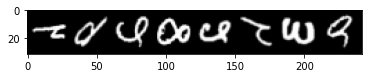

   h    9    2    8    2    h    3    a


In [ ]:
import numpy as np

#function to get class labels for EMNIST
def split(word):
    return [char for char in word]

#function to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(npimg)#np.transpose(npimg, (1, 2, 0)))
    plt.show()

classes = split('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz')
loaderbatch=8
loader = torch.utils.data.DataLoader(testset, batch_size=loaderbatch, shuffle=True)#, num_workers=2)

# get some random training images
dataiter = iter(loader)
images, labels = dataiter.next()

# show images & print labels
imshow(torchvision.utils.make_grid(images))
print(' '.join('%4s' % classes[labels[j]] for j in range(loaderbatch)))

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/data
PATH = './epoch39_state.pth'
print()

testmodel=ModelOfNet()
testmodel.load_state_dict(torch.load(PATH))
testmodel.eval()

avg_acc=0.0
for batchno,(inputs, labels) in enumerate(testloader, start=0):
        with torch.no_grad():
            # forward + loss on validation
            
            outputs = testmodel(inputs)
            assert outputs.shape[0]==labels.shape[0]
            loss = lossfunction(outputs, labels)

            outputsnp=(F.softmax(outputs)).numpy()
            outputsnp=np.argmax(outputsnp, axis=1)
           
            labelsnp=labels.numpy()

            count=0
            batch_acc=0.0
            for i in range(outputs.shape[0]):
              if outputsnp[i] == labelsnp[i]:
                count+=1
            batch_acc=(100*count)/(outputs.shape[0])
            avg_acc += (batch_acc)/nbatchtest
            #print(outputsnp)#.shape)
            #print(labelsnp)#.shape)
            #print(loss.item())
print("\n\nAverage Classification Accuracy over Test Set: ", avg_acc,"%")

/content/drive/MyDrive/Colab Notebooks/data



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.




Average Classification Accuracy over Test Set:  84.83051430142937 %


## **Image Processing**

#### **Image Input**
https://stackoverflow.com/questions/2828059/sorting-arrays-in-numpy-by-column

https://www.arxiv-vanity.com/papers/1702.05373/



IMAGE:


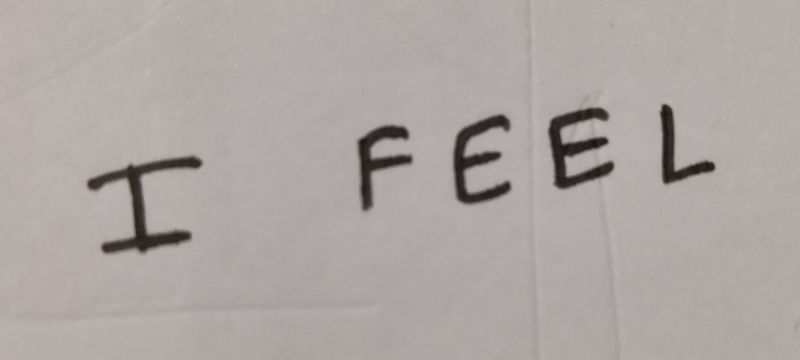

/content



BB Image:


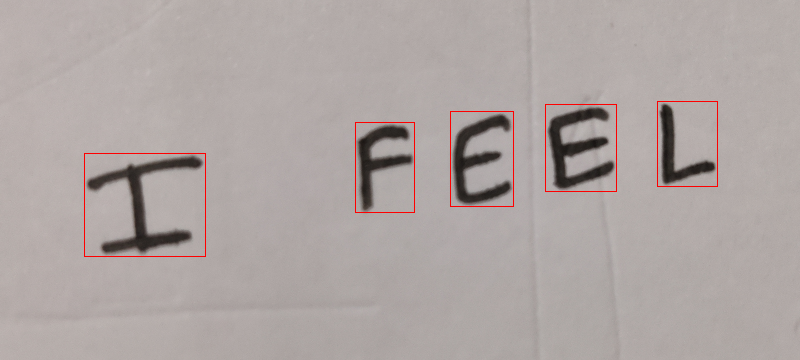

In [ ]:
import skimage
import numpy as np
from skimage.feature import hog
import cv2
import imutils
from google.colab.patches import cv2_imshow

imgdisplaywidth=800 
i=0
arr=[]

testimage=cv2.imread('/content/drive/My Drive/Pics/Ifeel.jpg')
testimage=imutils.resize(testimage, width=imgdisplaywidth)
testimagecpy=testimage.copy()
print("\nIMAGE:")
cv2_imshow(testimage)

gray = cv2.cvtColor(testimage, cv2.COLOR_BGR2GRAY)
gray2=gray.copy()
gray2=imutils.resize(gray2, width=imgdisplaywidth)
#print("\nGREYSCALE IMAGE:")
#cv2_imshow(gray2)

canny=cv2.Canny(gray, 118, 255)
canny2=canny.copy()
canny2=imutils.resize(canny2, width=imgdisplaywidth)
#print("\nCANNY EDGES IMAGE:")
#cv2_imshow(canny2)

cnts, heirarchy = cv2.findContours(canny.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
heirarray=heirarchy[0]
#print(cnts)
#print(len(heirarray), len(cnts))
for counter in range(len(heirarray)):
	if heirarray[(counter,3)]==-1:	
		x,y,w,h = cv2.boundingRect(cnts[counter])
		#bound the images
		#if w > 10 and h > 10:
		cv2.rectangle(gray,(x-1,y-1),(x+w,y+h),(255),-1)
#cv2_imshow(gray)

canny2=cv2.Canny(gray, 120,255)
#cv2_imshow(canny2)
cnts2, heirarchy2 = cv2.findContours(canny2.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
heirarray2=heirarchy2[0]
#print(cnts2)
#print(len(heirarray2), len(cnts2))
%cd /content/
for counter2 in range(len(heirarray2)):
  if heirarray2[(counter2,3)]==-1:	
    arr.append(cv2.boundingRect(cnts2[counter2]))
    x,y,w,h = cv2.boundingRect(cnts2[counter2])
    cv2.rectangle(testimagecpy,(x-1,y-1),(x+w,y+h),(0,0,255),1)

arr=np.array(arr)
#print(arr)
#print(arr.shape)
ind = np.argsort(arr[:,0])
arr = arr[ind]
for j in range(arr.shape[0]):
  # save individual images
  x,y,w,h = arr[j]
  runimg = testimage[y-20:y+h+20, x-20:x+w+20]
  runimg=cv2.cvtColor(cv2.resize(runimg, (128,128)), cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(runimg,(25,25),0)
  img = cv2.resize(blur,(28,28), interpolation=cv2.INTER_CUBIC)
  img=~img
  #ret,img = cv2.threshold(img,0,255,cv2.THRESH_OTSU)
  cv2_imshow(img)
  cv2.imwrite(str(j) + ".jpg", img)

print("\nBB Image:")
cv2_imshow(testimagecpy)
#print(arr)
#print(arr.shape)

In [ ]:
#%cd /content/drive/MyDrive/Colab Notebooks/data
PATH = '/content/drive/MyDrive/modelstate.pth'
print()

testmodel=ModelOfNet()
testmodel.load_state_dict(torch.load(PATH))
testmodel.eval()

import numpy as np

#function to get class labels for EMNIST
def split(word):
    return [char for char in word]
classes = split('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz')
print(classes,"\n")

paths=[]
for j in range(arr.shape[0]):
    strig='/content/'+str(j)+'.jpg'
    paths.append(strig)
    img=cv2.imread(strig)
    cv2_imshow(img)

print()
for j in range(arr.shape[0]):
  #if j==1:  
  path=paths[j]
  img=cv2.imread(path)
  img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
  img=torch.from_numpy(img)
  img=img.float()
  #print(img.shape)
  img=torch.reshape(img, (1,1,28,28))
  #print(img.shape)
  
  resultoftest=testmodel(img)
  resultoftest=F.softmax(resultoftest)
  #print(resultoftest)
  #print(resultoftest.sum())
  #print(resultoftest.shape)
  pred=np.array(torch.argmax(resultoftest, dim=1))
  #print(pred)
  print(classes[pred.item()])


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 




G
A
A
Q
D


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


####**Shreyas**


IMAGE:


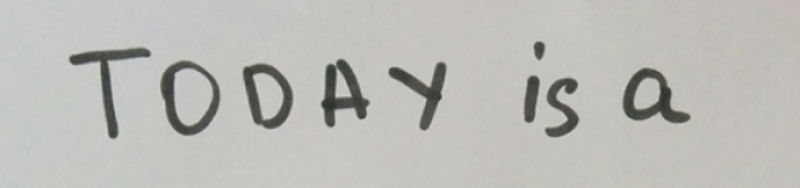

/content

BB Image:


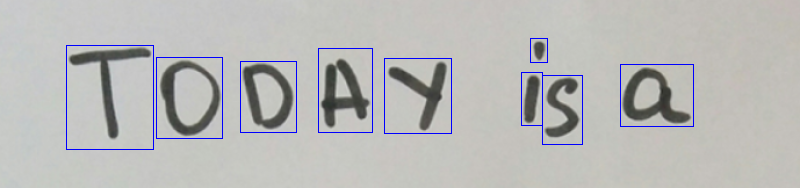

In [ ]:
import skimage
import numpy as np
from skimage.feature import hog
import cv2
import imutils
from google.colab.patches import cv2_imshow

imgdisplaywidth=800 
i=0
arr=[]

testimage=cv2.imread('/content/drive/My Drive/Colab Notebooks/Data/today_is_a.png')
testimage=imutils.resize(testimage, width=imgdisplaywidth)
testimagecpy=testimage.copy()
print("\nIMAGE:")
cv2_imshow(testimage)

gray = cv2.cvtColor(testimage, cv2.COLOR_BGR2GRAY)
gray2=gray.copy()
gray2=imutils.resize(gray2, width=imgdisplaywidth)
#print("\nGREYSCALE IMAGE:")
#cv2_imshow(gray2)

canny=cv2.Canny(gray, 10, 255)
canny2=canny.copy()
canny2=imutils.resize(canny2, width=imgdisplaywidth)
#print("\nCANNY EDGES IMAGE:")
#cv2_imshow(canny2)

cnts, heirarchy = cv2.findContours(canny.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
heirarray=heirarchy[0]
#print(cnts)
#print(len(heirarray), len(cnts))
for counter in range(len(heirarray)):
	if heirarray[(counter,3)]==-1:	
		x,y,w,h = cv2.boundingRect(cnts[counter])
		#bound the images
		#if w > 10 and h > 10:
		cv2.rectangle(gray,(x-1,y-1),(x+w,y+h),(255),-1)
#cv2_imshow(gray)

canny2=cv2.Canny(gray, 10,255)
#cv2_imshow(canny2)
cnts2, heirarchy2 = cv2.findContours(canny2.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
heirarray2=heirarchy2[0]
#print(cnts2)
#print(len(heirarray2), len(cnts2))
%cd /content/
for counter2 in range(len(heirarray2)):
  if heirarray2[(counter2,3)]==-1:	
    arr.append(cv2.boundingRect(cnts2[counter2]))
    x,y,w,h = cv2.boundingRect(cnts2[counter2])
    cv2.rectangle(testimagecpy,(x-1,y-1),(x+w,y+h),(255),1)

arr=np.array(arr)
#print(arr)
#print(arr.shape)
ind = np.argsort(arr[:,0])
arr = arr[ind]
for j in range(arr.shape[0]):
  # save individual images
  x,y,w,h = arr[j]
  runimg = testimage[y:y + h, x:x + w]
  runimg=cv2.cvtColor(runimg, cv2.COLOR_BGR2GRAY)
  runimg=cv2.resize(runimg, (28,28))
  runimg=cv2.bitwise_not(runimg)
  cv2.imwrite(str(j) + ".jpg", runimg)

print("\nBB Image:")
cv2_imshow(testimagecpy)
#print(arr)
#print(arr.shape)

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/data
PATH = './modelstate.pth'
print()

/content/drive/MyDrive/Colab Notebooks/data



In [ ]:
testmodel=ModelOfNet()
testmodel.load_state_dict(torch.load(PATH))
testmodel.eval()

import numpy as np

#function to get class labels for EMNIST
def split(word):
    return [char for char in word]
classes = split('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz')
print(classes,"\n")

paths=[]
for j in range(arr.shape[0]):
    strig='/content/'+str(j)+'.jpg'
    paths.append(strig)
    img=cv2.imread(strig)
    cv2_imshow(img)
print()
for j in range(arr.shape[0]):
  #if j==0:  
  path=paths[j]
  img=cv2.imread(path)
  img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
  img=torch.from_numpy(img)
  img=img.float()
  #print(img.shape)
  img=torch.reshape(img, (1,1,28,28))
  #print(img.shape)
  
  resultoftest=testmodel(img)
  resultoftest=F.softmax(resultoftest, dim=1)
  #print(resultoftest.shape)
  pred=np.array(torch.argmax(resultoftest, dim=1))
  #print(pred)
  print(classes[pred.item()])

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 




G
D
D
A
G
2
G
G
G


# **ROUGH WORK**

## **Training the Model**

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

https://stackoverflow.com/questions/17153779/how-can-i-print-variable-and-string-on-same-line-in-python

https://zhang-yang.medium.com/understanding-cross-entropy-implementation-in-pytorch-softmax-log-softmax-nll-cross-entropy-416a2b200e34

In [ ]:
def trainmodel(epochs=10):
  splitval=18001
  for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    mean_train_loss = 0.0
    mean_val_loss = 0.0
    for batchno,(inputs, labels) in enumerate(trainloader, start=0):
        # get the inputs, labels
        inputs, labels = inputs.to(device), labels.to(device)
        
        ########## TRAINING ##########
        if batchno<=splitval:
          # zero the parameter gradients
          updatefunction.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          assert outputs.shape[0]==labels.shape[0]
          loss = lossfunction(outputs, labels)
          loss.backward()
          updatefunction.step()

          # print statistics
          running_loss += loss.item()
          mean_train_loss += ((loss.item())/splitval)
          if batchno%1000==True:    # print every 1000 mini-batches
              print('[Epoch %d, Batch %5d]    train loss(prev. 1000 batches): %.5f'%(epoch, batchno, running_loss/1000))
              running_loss = 0.0

        ########## VALIDATION ##########
        
        if batchno>splitval:  
          # no gradient calc because validation
          with torch.no_grad():
            # forward + loss on validation
            outputs = model(inputs)
            assert outputs.shape[0]==labels.shape[0]
            loss = lossfunction(outputs, labels)

            # print statistics
            running_loss += loss.item()
            mean_val_loss += ((loss.item())/(nbatchtrain-splitval))
            if batchno%1000==True:    # print every 1000 mini-batches
                print('[Epoch %d, Batch %5d]    val loss(prev. 1000 batches): %.5f'%(epoch, batchno, running_loss/1000))
                running_loss = 0.0

    print("\nMean Training NLL Loss per batch in Epoch ", epoch,": ", mean_train_loss)
    print("Mean Validation NLL Loss per batch in Epoch ", epoch,": ", mean_val_loss,"\n\n")

  print('Finished Training')

In [ ]:
trainmodel(5)
!nvidia-smi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch 0, Batch     1]    train loss(prev. 1000 batches): 0.00818
[Epoch 0, Batch  1001]    train loss(prev. 1000 batches): 3.72497
[Epoch 0, Batch  2001]    train loss(prev. 1000 batches): 3.40783
[Epoch 0, Batch  3001]    train loss(prev. 1000 batches): 3.19158
[Epoch 0, Batch  4001]    train loss(prev. 1000 batches): 2.98405
[Epoch 0, Batch  5001]    train loss(prev. 1000 batches): 2.84315
[Epoch 0, Batch  6001]    train loss(prev. 1000 batches): 2.67782
[Epoch 0, Batch  7001]    train loss(prev. 1000 batches): 2.53085
[Epoch 0, Batch  8001]    train loss(prev. 1000 batches): 2.42860
[Epoch 0, Batch  9001]    train loss(prev. 1000 batches): 2.30893
[Epoch 0, Batch 10001]    train loss(prev. 1000 batches): 2.21352
[Epoch 0, Batch 11001]    train loss(prev. 1000 batches): 2.10221
[Epoch 0, Batch 12001]    train loss(prev. 1000 batches): 2.03644
[Epoch 0, Batch 13001]    train loss(prev. 1000 batches): 1.96366
[Epoch 0, Batch 14001]    train loss(prev. 1000 batches): 1.89209
[Epoch 0, 

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/data
PATH = './modelstate.pth'
torch.save(model.state_dict(), PATH)

/content/drive/MyDrive/Colab Notebooks/data


## **Testing the Model**
https://pytorch.org/tutorials/beginner/saving_loading_models.html

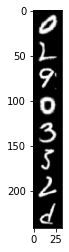

   0    2    9    0    3    5    2    d
tensor([ 0,  2,  9,  0,  3,  5,  2, 39])


In [ ]:
import numpy as np

#function to get class labels for EMNIST
def split(word):
    return [char for char in word]

#function to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg))#, (1, 2, 0)))
    plt.show()

classes = split('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz')
loaderbatch=8
loader = torch.utils.data.DataLoader(testset, batch_size=loaderbatch, shuffle=True)#, num_workers=2)

# get some random training images
dataiter = iter(loader)
images, labels = dataiter.next()

# show images & print labels
imshow(torchvision.utils.make_grid(images))
print(' '.join('%4s' % classes[labels[j]] for j in range(loaderbatch)))
print(labels)

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/data
PATH = './modelstate.pth'
print()

testmodel=ModelOfNet()
testmodel=testmodel.to(device) 
testmodel.load_state_dict(torch.load(PATH))
testmodel.eval()

avg_acc=0.0
for batchno,(inputs, labels) in enumerate(testloader, start=0):
        with torch.no_grad():
            # forward + loss on validation
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = testmodel(inputs)
            assert outputs.shape[0]==labels.shape[0]
            loss = lossfunction(outputs, labels)

            outputs=outputs.cpu()
            outputsnp=(F.softmax(outputs)).numpy()
            outputsnp=np.argmax(outputsnp, axis=1)
           
            labelsnp=(labels.cpu()).numpy()

            count=0
            batch_acc=0.0
            for i in range(outputs.shape[0]):
              if outputsnp[i] == labelsnp[i]:
                count+=1
            batch_acc=(100*count)/(outputs.shape[0])
            avg_acc += (batch_acc)/nbatchtest
            #print(outputsnp)#.shape)
            #print(labelsnp)#.shape)
            #print(loss.item())
print("\n\nAverage Classification Accuracy over Test Set: ", avg_acc,"%")

/content/drive/MyDrive/Colab Notebooks/data



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.




Average Classification Accuracy over Test Set:  77.86315089842275 %


## Shreyas 

Getting Started With Contours:
https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html#:~:text=Contours%20can%20be%20explained%20simply,better%20accuracy%2C%20use%20binary%20images.

Contours Hierarchy:
https://docs.opencv.org/master/d9/d8b/tutorial_py_contours_hierarchy.html

In [ ]:
import skimage
import numpy as np
from skimage.feature import hog
import cv2
import imutils
from google.colab.patches import cv2_imshow


IMAGE:


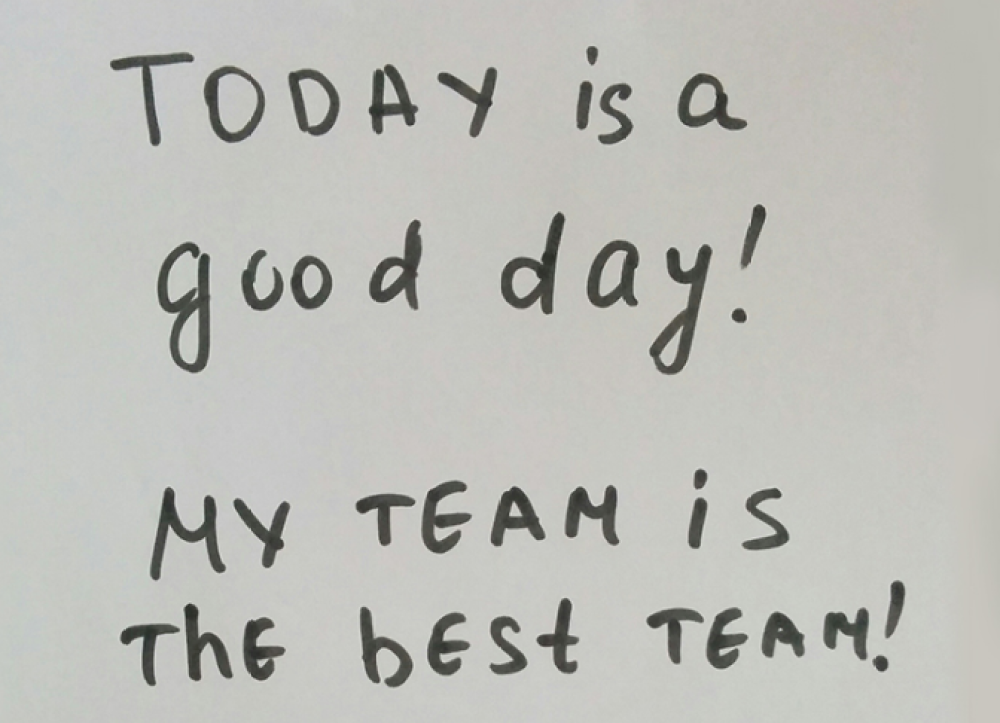


CANNY EDGES IMAGE:


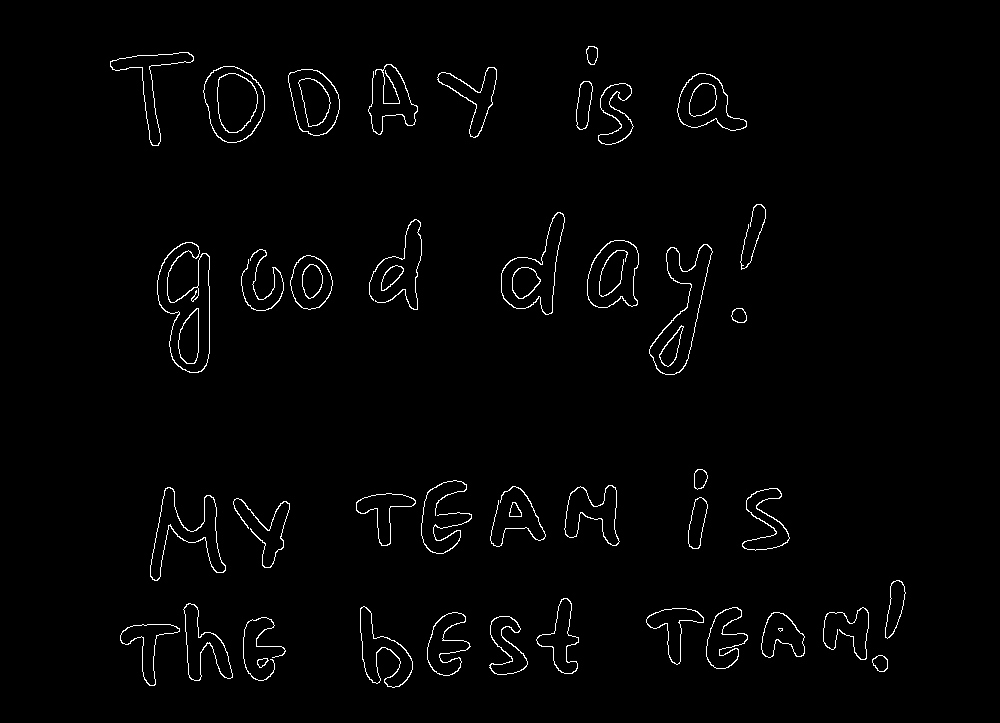

94 94


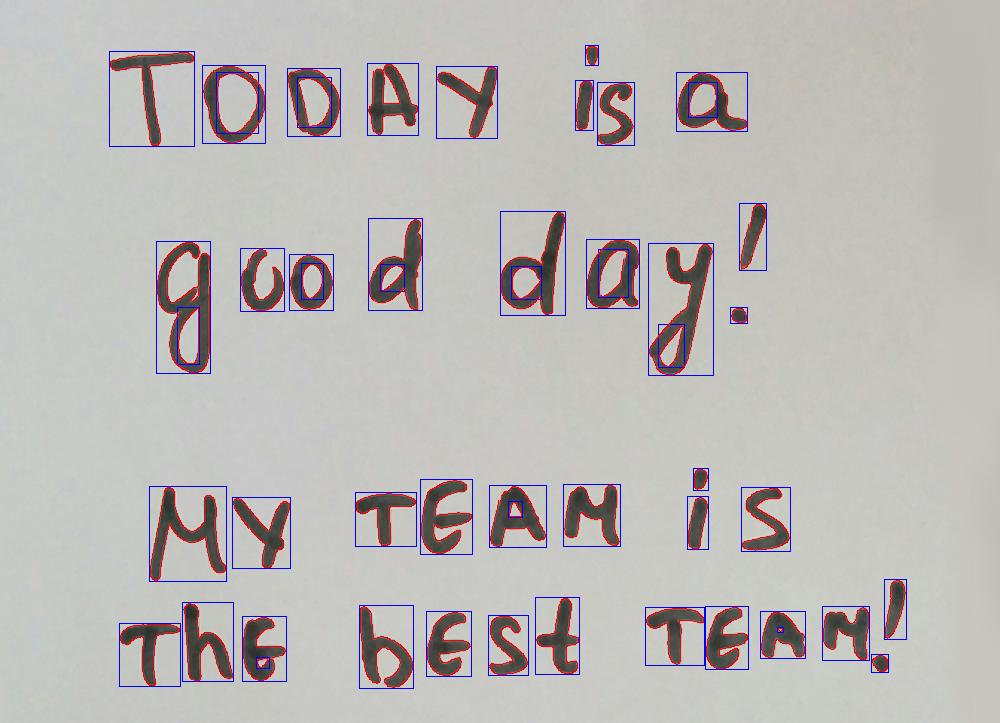

In [ ]:
imgdisplaywidth=1000 

testimage=cv2.imread('/content/drive/My Drive/Colab Notebooks/Data/handwritten_text.png')
testimage=imutils.resize(testimage, width=imgdisplaywidth)
testimagecpy=testimage.copy()
print("\nIMAGE:")
cv2_imshow(testimage)
canny=cv2.Canny(testimage, 100, 255)
canny2=canny.copy()
canny2=imutils.resize(canny2, width=imgdisplaywidth)
print("\nCANNY EDGES IMAGE:")
cv2_imshow(canny2)

cnts, hierarchy = cv2.findContours(canny.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
#hierarchy is an array with elements being [Next, Previous, First_Child, Parent]
hierarray=hierarchy[0]
# print(cnts)
print(len(hierarray), len(cnts))
for counter in range(len(hierarray)):
	if hierarray[(counter,3)]==-1:	  #if there is no parent contour
		x,y,w,h = cv2.boundingRect(cnts[counter])  # (x,y) is the top left corner of bounding rectangle and w,h are width, height
		#bound the images
		# if w > 10 and h > 10:
		cv2.rectangle(testimage,(x-1,y-1),(x+w,y+h),(255),0)   
#last argument -1 to get filled rectangle, this argument denotes "thickness" of rectangle around the letter
cv2.drawContours(testimage, cnts, -1, (0, 0, 255), 1)
cv2_imshow(testimage)

How to choose hyperparameters for NN

https://stats.stackexchange.com/questions/95495/guideline-to-select-the-hyperparameters-in-deep-learning#:~:text=Grid%20Search%3A%20Using%20knowledge%20you,the%20combination%20that%20performs%20best.

https://ai.stackexchange.com/questions/8560/how-do-i-choose-the-optimal-batch-size



In [ ]:
class ModelOfNet(nn.Module):
    def __init__(self):
        super(ModelOfNet,self).__init__()

        self.convolve=nn.Sequential(
                nn.Conv2d(1,8,3,1,1),
                nn.ReLU(),
                nn.Conv2d(8,16,3,1,1),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                nn.MaxPool2d(2,2),
                nn.Conv2d(16,16,3,1,1),
                nn.ReLU(),
                nn.Conv2d(16,32,3,1,1),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2,2),
        )
        self.fullyconnect1=nn.Linear(1568,200)
        self.fullyconnect2=nn.Linear(200,62)

    def forward(self, x):
        x=self.convolve(x)
        x=x.view(x.size(0),-1)
        x=self.fullyconnect1(x)
        x=self.fullyconnect2(x)
        return x




In [ ]:
batchsize=32;

nbatchtrain=np.ceil(len(trainset)/batchsize)
nbatchtest=np.ceil(len(testset)/batchsize)
print(nbatchtrain,nbatchtest)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)#, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=True)#, num_workers=2)

21811.0 3636.0


In [ ]:
def trainmodel(epochs=10):
  splitval=18001
  for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    mean_train_loss = 0.0
    mean_val_loss = 0.0
    for batchno,(inputs, labels) in enumerate(trainloader, start=0):
        # get the inputs, labels
        inputs, labels = inputs.to(device), labels.to(device)
        
        ########## TRAINING ##########
        if batchno<=splitval:
          # zero the parameter gradients
          updatefunction.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          assert outputs.shape[0]==labels.shape[0]
          loss = lossfunction(outputs, labels)
          loss.backward()
          updatefunction.step()

          # print statistics
          running_loss += loss.item()
          mean_train_loss += ((loss.item())/splitval)
          if batchno%1000==True:    # print every 1000 mini-batches
              print('[Epoch %d, Batch %5d]    train loss(prev. 1000 batches): %.5f'%(epoch, batchno, running_loss/1000))
              running_loss = 0.0

        ########## VALIDATION ##########
        
        if batchno>splitval:  
          # no gradient calc because validation
          with torch.no_grad():
            # forward + loss on validation
            outputs = model(inputs)
            assert outputs.shape[0]==labels.shape[0]
            loss = lossfunction(outputs, labels)

            # print statistics
            running_loss += loss.item()
            mean_val_loss += ((loss.item())/(nbatchtrain-splitval))
            if batchno%1000==True:    # print every 1000 mini-batches
                print('[Epoch %d, Batch %5d]    val loss(prev. 1000 batches): %.5f'%(epoch, batchno, running_loss/1000))
                running_loss = 0.0

    print("\nMean Training Loss per batch in Epoch ", epoch,": ", mean_train_loss)
    print("Mean Validation Loss per batch in Epoch ", epoch,": ", mean_val_loss,"\n\n")

  print('Finished Training')

In [ ]:
model=ModelOfNet()
model=model.to(device)    #Transfer model to GPU, Data will be transferred in the validation/training time code
print(model)

learningrate=1e-6
lossfunction=torch.nn.CrossEntropyLoss()
updatefunction=torch.optim.Adam(model.parameters(), lr=learningrate)

print('completed running block')

ModelOfNet(
  (convolve): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fullyconnect1): Linear(in_features=1568, out_features=200, bias=True)
  (fullyconnect2): Linear(in_features=200, out_features=62, bias=True)
)
completed running block


In [ ]:
print(lossfunction)
print(updatefunction)

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-06
    weight_decay: 0
)


In [ ]:
trainmodel()

[Epoch 0, Batch     1]    train loss(prev. 1000 batches): 0.00853
[Epoch 0, Batch  1001]    train loss(prev. 1000 batches): 3.84001
[Epoch 0, Batch  2001]    train loss(prev. 1000 batches): 3.38079
[Epoch 0, Batch  3001]    train loss(prev. 1000 batches): 3.08254
[Epoch 0, Batch  4001]    train loss(prev. 1000 batches): 2.83627
[Epoch 0, Batch  5001]    train loss(prev. 1000 batches): 2.64207
[Epoch 0, Batch  6001]    train loss(prev. 1000 batches): 2.45517
[Epoch 0, Batch  7001]    train loss(prev. 1000 batches): 2.30633
[Epoch 0, Batch  8001]    train loss(prev. 1000 batches): 2.20433
[Epoch 0, Batch  9001]    train loss(prev. 1000 batches): 2.07138
[Epoch 0, Batch 10001]    train loss(prev. 1000 batches): 1.98148
[Epoch 0, Batch 11001]    train loss(prev. 1000 batches): 1.89707
[Epoch 0, Batch 12001]    train loss(prev. 1000 batches): 1.81418
[Epoch 0, Batch 13001]    train loss(prev. 1000 batches): 1.74024
[Epoch 0, Batch 14001]    train loss(prev. 1000 batches): 1.67124
[Epoch 0, 

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/data
PATH = './modelstate.pth'
torch.save(model.state_dict(), PATH)

/content/drive/My Drive/Colab Notebooks/data


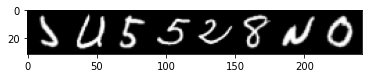

   J    U    5    5    2    8    N    0


In [ ]:
import numpy as np

#function to get class labels for EMNIST
def split(word):
    return [char for char in word]

#function to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

classes = split('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz')
loaderbatch=8
loader = torch.utils.data.DataLoader(testset, batch_size=loaderbatch, shuffle=True)#, num_workers=2)

# get some random training images
dataiter = iter(loader)
images, labels = dataiter.next()

# show images & print labels
imshow(torchvision.utils.make_grid(images))
print(' '.join('%4s' % classes[labels[j]] for j in range(loaderbatch)))

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/data
PATH = './modelstate.pth'
print()

testmodel=ModelOfNet()
testmodel.load_state_dict(torch.load(PATH))
testmodel.eval()

avg_acc=0.0
for batchno,(inputs, labels) in enumerate(testloader, start=0):
        with torch.no_grad():
            # forward + loss on validation
            
            outputs = testmodel(inputs)
            assert outputs.shape[0]==labels.shape[0]
            loss = lossfunction(outputs, labels)

            outputsnp=(F.softmax(outputs)).numpy()
            outputsnp=np.argmax(outputsnp, axis=1)
           
            labelsnp=labels.numpy()

            count=0
            batch_acc=0.0
            for i in range(outputs.shape[0]):
              if outputsnp[i] == labelsnp[i]:
                count+=1
            batch_acc=(100*count)/(outputs.shape[0])
            avg_acc += (batch_acc)/nbatchtest
            #print(outputsnp)#.shape)
            #print(labelsnp)#.shape)
            #print(loss.item())
print("\n\nAverage Classification Accuracy over Test Set: ", avg_acc,"%")

/content/drive/My Drive/Colab Notebooks/data



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.




Average Classification Accuracy over Test Set:  82.40081820682013 %


#### One Hidden Layer

Tweaking the value of hidden layer size and checking training loss for first epoch

In [ ]:
for hidden_size in [124, 248, 496, 992]:

  class ModelOfNet_test(nn.Module):
    def __init__(self):
        super(ModelOfNet_test,self).__init__()

        self.convolve=nn.Sequential(
                nn.Conv2d(1,8,3,1,1),
                nn.ReLU(),
                nn.Conv2d(8,16,3,1,1),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                nn.MaxPool2d(2,2),
                nn.Conv2d(16,16,3,1,1),
                nn.ReLU(),
                nn.Conv2d(16,32,3,1,1),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2,2),
        )
        self.fullyconnect1=nn.Linear(1568,hidden_size)
        self.fullyconnect2=nn.Linear(hidden_size,62)

    def forward(self, x):
        x=self.convolve(x)
        x=x.view(x.size(0),-1)
        x=self.fullyconnect1(x)
        x=self.fullyconnect2(x)
        return x

  model=ModelOfNet_test()
  model=model.to(device)    #Transfer model to GPU, Data will be transferred in the validation/training time code
  print(model)

  learningrate=1e-6
  lossfunction=torch.nn.CrossEntropyLoss()
  updatefunction=torch.optim.Adam(model.parameters(), lr=learningrate)

  print('completed running block')

  trainmodel()

ModelOfNet_test(
  (convolve): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fullyconnect1): Linear(in_features=1568, out_features=124, bias=True)
  (fullyconnect2): Linear(in_features=124, out_features=62, bias=True)
)
completed running block
[Epoch 0, Batch     1]    train loss(prev. 1000 batches): 0.00840
[Epoch 0

In [ ]:
class ModelOfNet_test(nn.Module):
  def __init__(self):
      super(ModelOfNet_test,self).__init__()

      self.convolve=nn.Sequential(
              nn.Conv2d(1,8,3,1,1),
              nn.ReLU(),
              nn.Conv2d(8,16,3,1,1),
              nn.ReLU(),
              nn.BatchNorm2d(16),
              nn.MaxPool2d(2,2),
              nn.Conv2d(16,16,3,1,1),
              nn.ReLU(),
              nn.Conv2d(16,32,3,1,1),
              nn.ReLU(),
              nn.BatchNorm2d(32),
              nn.MaxPool2d(2,2),
      )
      self.fullyconnect1=nn.Linear(1568, 1984)
      self.fullyconnect2=nn.Linear(1984,62)

  def forward(self, x):
      x=self.convolve(x)
      x=x.view(x.size(0),-1)
      x=self.fullyconnect1(x)
      x=self.fullyconnect2(x)
      return x

model=ModelOfNet_test()
model=model.to(device)    #Transfer model to GPU, Data will be transferred in the validation/training time code
print(model)

learningrate=1e-6
lossfunction=torch.nn.CrossEntropyLoss()
updatefunction=torch.optim.Adam(model.parameters(), lr=learningrate)

print('completed running block')

trainmodel()

ModelOfNet_test(
  (convolve): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fullyconnect1): Linear(in_features=1568, out_features=1984, bias=True)
  (fullyconnect2): Linear(in_features=1984, out_features=62, bias=True)
)
completed running block
[Epoch 0, Batch     1]    train loss(prev. 1000 batches): 0.00860
[Epoch

###Two Hidden Layers

In [ ]:
for (hidden_size_1, hidden_size_2) in [(1984, 992), (1488, 992), (992, 496), (496, 248)]:

  class ModelOfNet_test(nn.Module):
    def __init__(self):
        super(ModelOfNet_test,self).__init__()

        self.convolve=nn.Sequential(
                nn.Conv2d(1,8,3,1,1),
                nn.ReLU(),
                nn.Conv2d(8,16,3,1,1),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                nn.MaxPool2d(2,2),
                nn.Conv2d(16,16,3,1,1),
                nn.ReLU(),
                nn.Conv2d(16,32,3,1,1),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2,2),
        )
        self.fullyconnect1=nn.Linear(1568,hidden_size_1)
        self.fullyconnect2=nn.Linear(hidden_size_1,hidden_size_2)
        self.fullyconnect3=nn.Linear(hidden_size_2,62)

    def forward(self, x):
        x=self.convolve(x)
        x=x.view(x.size(0),-1)
        x=self.fullyconnect1(x)
        x=self.fullyconnect2(x)
        x=self.fullyconnect3(x)
        return x

  model=ModelOfNet_test()
  model=model.to(device)    #Transfer model to GPU, Data will be transferred in the validation/training time code
  print(model)

  learningrate=1e-6
  lossfunction=torch.nn.CrossEntropyLoss()
  updatefunction=torch.optim.Adam(model.parameters(), lr=learningrate)

  print('completed running block')

  trainmodel()

###Three Hidden Layers

In [ ]:
for (hidden_size_1, hidden_size_2, hidden_size_3) in [(1984, 992, 496), (1488, 992, 496)]:

  class ModelOfNet_test(nn.Module):
    def __init__(self):
        super(ModelOfNet_test,self).__init__()

        self.convolve=nn.Sequential(
                nn.Conv2d(1,8,3,1,1),
                nn.ReLU(),
                nn.Conv2d(8,16,3,1,1),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                nn.MaxPool2d(2,2),
                nn.Conv2d(16,16,3,1,1),
                nn.ReLU(),
                nn.Conv2d(16,32,3,1,1),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2,2),
        )
        self.fullyconnect1=nn.Linear(1568,hidden_size_1)
        self.fullyconnect2=nn.Linear(hidden_size_1,hidden_size_2)
        self.fullyconnect3=nn.Linear(hidden_size_2,hidden_size_3)
        self.fullyconnect4=nn.Linear(hidden_size_3,62)

    def forward(self, x):
        x=self.convolve(x)
        x=x.view(x.size(0),-1)
        x=self.fullyconnect1(x)
        x=self.fullyconnect2(x)
        x=self.fullyconnect3(x)
        x=self.fullyconnect4(x)
        return x

  model=ModelOfNet_test()
  model=model.to(device)    #Transfer model to GPU, Data will be transferred in the validation/training time code
  print(model)

  learningrate=1e-6
  lossfunction=torch.nn.CrossEntropyLoss()
  updatefunction=torch.optim.Adam(model.parameters(), lr=learningrate)

  print('completed running block')

  trainmodel()

In [ ]:
for learningrate in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]:
  print("Learning Rate: ", learningrate)
  # print(model)
  # learningrate=1e-6
  lossfunction=torch.nn.CrossEntropyLoss()
  updatefunction=torch.optim.Adam(model.parameters(), lr=learningrate)
  # print('Completed running block')
  trainmodel()

Learning Rate:  1e-06
[Epoch 0, Batch     1]    train loss(prev. 1000 batches): 0.00826
[Epoch 0, Batch  1001]    train loss(prev. 1000 batches): 3.24511
[Epoch 0, Batch  2001]    train loss(prev. 1000 batches): 2.38794
[Epoch 0, Batch  3001]    train loss(prev. 1000 batches): 1.95972
[Epoch 0, Batch  4001]    train loss(prev. 1000 batches): 1.68804
[Epoch 0, Batch  5001]    train loss(prev. 1000 batches): 1.49936
[Epoch 0, Batch  6001]    train loss(prev. 1000 batches): 1.36266
[Epoch 0, Batch  7001]    train loss(prev. 1000 batches): 1.24693
[Epoch 0, Batch  8001]    train loss(prev. 1000 batches): 1.16016
[Epoch 0, Batch  9001]    train loss(prev. 1000 batches): 1.11387
[Epoch 0, Batch 10001]    train loss(prev. 1000 batches): 1.05083
[Epoch 0, Batch 11001]    train loss(prev. 1000 batches): 0.99076
[Epoch 0, Batch 12001]    train loss(prev. 1000 batches): 0.94528
[Epoch 0, Batch 13001]    train loss(prev. 1000 batches): 0.91969
[Epoch 0, Batch 14001]    train loss(prev. 1000 batche

## Aayush

### For line segmentation (answers also include character segmentation)
https://stackoverflow.com/questions/46282691/opencv-cropping-handwritten-lines-line-segmentation

### Page Segmentation
https://medium.com/apache-mxnet/page-segmentation-with-gluon-dcb4e5955e2

In [ ]:
class ModelOfNet(nn.Module):
    def __init__(self):
        super(ModelOfNet,self).__init__()

        self.convolve=nn.Sequential(
                nn.Conv2d(1,8,3,1,1),
                nn.ReLU(),
                nn.Conv2d(8,16,3,1,1),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                nn.MaxPool2d(2,2),
                nn.Conv2d(16,16,3,1,1),
                nn.ReLU(),
                nn.Conv2d(16,32,3,1,1),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2,2),
        )
        self.fullyconnect=nn.Linear(1568,62)

    def forward(self, x):
        x=self.convolve(x)
        x=x.view(x.size(0),-1)
        x=self.fullyconnect(x)
        x=F.log_softmax(x)
        return x 

In [ ]:
model=ModelOfNet()
model=model.to(device)    #Transfer model to GPU, Data will be transferred in the validation/training time code
print(model)

learningrate=1e-6
lossfunction=torch.nn.NLLLoss()
updatefunction=torch.optim.Adam(model.parameters(), lr=learningrate)

print('completed running block')

ModelOfNet(
  (convolve): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fullyconnect): Linear(in_features=1568, out_features=62, bias=True)
)
completed running block


In [ ]:
print(lossfunction)
print(updatefunction)

NLLLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-06
    weight_decay: 0
)
